<a href="https://colab.research.google.com/github/polcord/ClassificationModel/blob/main/Preparacion_modelamiento_desercion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <center>  Preparación y modelamiento de datos para Deserción </center>

- Nota: Este notebook fue ejecutado en la plataforma Google Colaboratory

## Descripción

- En esta sección utilizaremos procesos de ingeniería de variable y limpieza de datos para preparar el conjunto de datos antes del entrenamiento de los algoritmos.
- Posteriomente, se ejecutarán los algoritmos de Regresión Logística y Random Forest para encontrar el algoritmo campeón.


### Preguntas

1. Encontrar las variables más relevantes para discriminar entre clientes que
desertan y clientes que no desertan.

**Respuesta:** 'CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Gender'

2. Elaborar un modelo logit con las variables que identificadas que más discriminan la deserción.

**Respuesta:** Se implementó un modelo logit con regularización y balanceo de datos según la variable objetivo

3. Comentar e interpretar los resultados del modelo logit.

**Respuesta:** Mantiniendo el resto de predictores constantes (ceteris paribus), el aporte de cada predictor fue el siguiente:

- CreditScore: Cuando el creditScore aumenta en una unidad (por ejemplo, de 600 a 601), las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) disminuyen en aproximadamente un 6.85%.
- Age: Cuando la edad aumenta en una unidad, las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) aumentan en aproximadamente 134.17%.
- Balance: Cuando el saldo aumenta en una unidad, las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) aumentan en aproximadamente 37.44%.
- NumOfProducts: Cuando el número de productos (NumOfProducts) aumenta en una unidad, las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) disminuyen en aproximadamente 8.78%.
- IsActiveMember: Cuando el estado de ser miembro activo (IsActiveMember) cambia de 0 a 1, las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) disminuyen en aproximadamente 51.42%. Esto sugiere que los clientes que son miembros activos tienen menores odds de desertar en comparación con los que no son miembros activos.
- EstimatedSalary: Cuando el salario estimado (EstimatedSalary) aumenta en una unidad, las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) aumentan en aproximadamente 4.20%.
- Geography_Germany: Si el cliente es de Alemania (Geography_Germany), las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) aumentan en aproximadamente 75.80% en comparación con el caso base de la geografía de referencia (France).
- Geography_Spain: Si el cliente es de España (Geography_Spain), las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) disminuyen en aproximadamente 2.05% en comparación con el caso base de la geografía de referencia (France).
- Gender_Male: Si el género del cliente es masculino (Gender_Male), las odds de que ocurra el evento "éxito" (por ejemplo, un cliente deserte) disminuyen en aproximadamente 37.56% en comparación con el caso base del género de referencia (Female).

4. Elaborar un modelo competidor (el que tú elijas) con las mismas variables.

Se comparó contra el modelo de Ramdom Forest.

5. Comentar e interpretar los resultados del modelo.

El modelo de regresión logística presento en el Auc del modelo los siguientes resultados:

Train 0.77 | Test 0.75

Lo cual nos permite intuir la no presencia de overfitting del modelo. Se espera que el Auc sea cercano a 1 (modelo perfecto); pero con datos del mundo real tener un auc de 0.75 (gini de 0.5) es aceptable.

6. Comparar los resultados del modelo logit vs el modelo competidor. ¿Cuál es mejor?
¿Por qué?

Se compararon los resultados en test de ambos modelos teniendo los siguientes resultados:

Regresión Logística Test 0.75 | Random Forest Test 0.86

Por lo cual se puede concluir que el modelo de Random Forest tiene un mejor desempeño en datos que no ha visto el modelo al ser mayor su valor de auc en los datos de test.

**A continuación, encuentra el código que detalla la respuesta a cada una de las preguntas antes expuestas.**

## Importar librerías y verificar versiones

In [ ]:
import sys
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib
import math

In [ ]:
print('** Versiones Actuales | Requeridas **')
print('Python:\nVersion Actual:', sys.version, ' | Requerida >= 3.6')
print('NumPy:\nVersion Actual: {:10} | Requerida >= 1.16.2'.format(np.__version__))
print('Pandas:\nVersion Actual: {:10}| Requerida >= 0.24.2'.format(pd.__version__))
print('Scikit-learn:\nVersion Actual: {:10}| Requerida >= 1.2.1'.format(sk.__version__))
print('Matplotlib:\nVersion Actual: {:10} | Requerida >= 3.0.3'.format(matplotlib.__version__))
print('Seaborn:\nVersion Actual: {:10} |Requerida >= 0.9.0 '.format(sns.__version__))

** Versiones Actuales | Requeridas **
Python:
Version Actual: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]  | Requerida >= 3.6
NumPy:
Version Actual: 1.23.5     | Requerida >= 1.16.2
Pandas:
Version Actual: 1.5.3     | Requerida >= 0.24.2
Scikit-learn:
Version Actual: 1.2.2     | Requerida >= 1.2.1
Matplotlib:
Version Actual: 3.7.1      | Requerida >= 3.0.3
Seaborn:
Version Actual: 0.12.2     |Requerida >= 0.9.0 


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import matplotlib.pyplot as plt

## Carga de los datos

Se creó un dataframe de Python para trabajar con el conjunto de datos estructurados de los clientes. En este sentido, se realizaron los cálculos y operaciones respectivas para crear la variable objetivo y aplicar la limpieza de datos necesaria para el proceso.

Con ello, se disponen de 10000 registros en el conjunto de datos.

In [ ]:
# Ruta del directorio en la nube
ruta1 = 'https://raw.githubusercontent.com/vmoprojs/DataLectures/master/Bank_churn_modelling.csv'

# Lectura de los datos usando pandas (creación de DataFrames)
datos = pd.read_csv(ruta1,
                    header = 0,
                    sep = ',',
                    quotechar='"',
                    encoding = 'utf-8')

datos['Geography'] = datos.Geography.str.strip()

datos = datos.sample(frac=1, random_state=42)

print('\n No. filas y columnas', datos.shape)

datos.head()


 No. filas y columnas (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


### Selección de variable objetivo y predictores del DataFrame

La nomeclatura estándar para la variable objetivo sera `y`, mientras que para los predictores `X`.

In [ ]:
# Almacenamos en una nueva variable a nuestro target
target = 'Exited'
y = datos.loc[:, target]

En base al análisis exploratorio de datos y al criterio experto se identificaron los siguientes aspectos a partir del ***Reporte_df_desercion.html***:

- No se encuentran valores perdidos (missing) dentro del conjunto de datos.
- Existe un desbalance en nuestra variable objetivo **Exited** cerca de un 79.6% no han presentado deserción (esto es lógico de acuerdo a la dinámica del proceso).
- El campo de Credit Score presenta una concentración de valores considerable en el valor de 850 (al compararlo con el resto de la distribución)
- El campo Balance tiene una concentración de 36.2% en el valor de cero

Esto aspectos seran controlados durante el transcurso del proceso.

In [ ]:
# Seleccionar predictores
cols_que_no_aportan = ['RowNumber', 'CustomerId', 'Surname']

campos_excluidos = cols_que_no_aportan + [target]

X = datos.loc[:, [i for i in datos.columns if i not in campos_excluidos]]

A continuación, se muestran los campos que se emplearán para el proceso de preparación de datos antes del modelamiento.

In [ ]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

### División en datos de training y test

Se requiere separar una parte del conjunto de datos para el entrenamiento del modelo y otra para validar los resultados.

El conjunto de datos de validación no forma parte del entrenamiento y será de utilidad para el ejercicio de predicción para nuevos datos; permitiendo corroborar el desempeño del modelo.

Se determina el uso de una semilla, para mantener la reproducibilidad de la división aleatoria de los datos. Un 80% se destinará para el entrenamiento y un 20% para validación (contraste de métricas).

Adicionalmente se aplica el muestreo estratificado para que se mantenga una misma proporción de clientes que han desertado o no dentro de las divisiones de train y test.

In [ ]:
SEED = 42

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [ ]:
y_train.value_counts(normalize = True)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

In [ ]:
y_test.value_counts(normalize = True)

0    0.7965
1    0.2035
Name: Exited, dtype: float64

El número de clientes con los que será entrenado el modelo será de 8000 registros y será evaluado con 2000 registros.

In [ ]:
# Imprimir las filas y columnas de los datos de training y test: para los predictores y para la variables objetivo
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 10) (2000, 10) (8000,) (2000,)


### Ingeniería de variable para variables numéricas y categóricas

In [ ]:
# Selección de los nombres de las variables numéricas
X_num = X_train.select_dtypes(include=np.number).columns
print(X_num)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [ ]:
# Selección de los nombres de las variables categóricas
X_cat = X_train.select_dtypes(include=object).columns
print(X_cat)

Index(['Geography', 'Gender'], dtype='object')


### Selección de Features

En el contexto de la selección de predictores, si tienes un valor p mayor a 0.05 después de realizar una prueba chi2 para una variable predictora, se sugiere que esa variable puede no ser estadísticamente relevante para predecir la variable objetivo en el modelo.

Por lo cual se decide descartar a los predictores: HasCrCard	Y Tenure

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first'))])

preprocessor_selection_features = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_num),
        ('cat', categorical_transformer, X_cat)], verbose_feature_names_out=True)

feature_selection = Pipeline(steps=[('preprocessor', preprocessor_selection_features),
                                    ('selector', SelectKBest(score_func=chi2, k=11))])

chi2_selector = feature_selection.fit(X_train, y_train)[-1]

columns_selector_chi2 = preprocessor_selection_features.fit(X_train, y_train).get_feature_names_out().tolist()

chi2_scores = pd.DataFrame(list(zip(columns_selector_chi2, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval']).round(3)
chi2_scores.sort_values('score', ascending=False)

,ftr,score,pval
3,num__Balance,5613014.512,0.000
7,num__EstimatedSalary,55105.726,0.000
1,num__Age,1921.884,0.000
8,cat__Geography_Germany,179.158,0.000
6,num__IsActiveMember,91.931,0.000
0,num__CreditScore,81.267,0.000
10,cat__Gender_Male,49.333,0.000
9,cat__Geography_Spain,15.166,0.000
4,num__NumOfProducts,4.651,0.031
2,num__Tenure,0.782,0.376


In [ ]:
X_num = [i for i in X_train.select_dtypes(include=np.number).columns if i not in ['HasCrCard', 'Tenure']]
print(X_num)

['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary']


### Pipeline - Ingeniería de variable

Se distingue el tratamiento o ingeniería de variables para los campos númericos y categóricos.

**Variables numéricas**

Para cada campo se procede a realizar la imputación de los valores perdidos por la mediana, medida de tendencia central que no es influenciable por valores atípicos/extremos. Esto en caso de que en algún momento se presenten valores perdidos aunque no es el caso en este conjunto de datos.

Posterior se ejecutó el proceso de estandarización robusta para que la magnitud de las variables sea comparable y considere la presencia de outliers (a partir del rango intercuatílico).

Fórmula: z = (x - u) / s

Donde para columna se resta su media (x) y se divide para su desviación estándar (s), para que no se ejerza una influencia de algunas variables por su escala (influencia por su varianza).

**Variables categóricas**

Para estas variables se aplica el proceso denominado "One Hot Encoding" que consiste en que por cada categória de un campo se crean nuevos campos con valores de 0 y 1.

In [ ]:
# Creación de un Pipeline para el preprocesamiento de las variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first'))])

In [ ]:
# Delimitar el preprocesamiento de variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_num),
        ('cat', categorical_transformer, X_cat)], verbose_feature_names_out=True)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['CreditScore', 'Age', 'Balance',
                                  'NumOfProducts', 'IsActiveMember',
                                  'EstimatedSalary']),
                                ('cat',
                                 Pipeline(steps=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['Geography', 'Gender'], dtype='object'))])

In [ ]:
# Almacenar el nombre de las variables transformadas
column_transformed_names = preprocessor.fit(X_train, y_train).get_feature_names_out().tolist()

## Modelamiento

Se delimita que la métrica de interés será el AUC dado el desbalance en las categorías de la variable objetivo.

In [ ]:
metrica = 'roc_auc'

### Modelo de Regresión Logística

Aplicamos el balanceo de datos que tiene por defecto el paquete de sklearn en la regresión logística.

In [ ]:
reg_log = LogisticRegression(class_weight='balanced', n_jobs = -1)

In [ ]:
# Creción de Pipeline procesamiento y entrenamiento
reg_log_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', reg_log)])

In [ ]:
# Validación Cruzada
%%time
param_grid_reg_log = {'regressor__C': [0.01, 0.05 , 1.]}

grid_reg_log = GridSearchCV(cv = 10,
                               param_grid = param_grid_reg_log,
                               estimator = reg_log_pipeline,
                               scoring = metrica,
                               n_jobs = -1)

grid_reg_log.fit(X_train, y_train)

# Imprimir el hiperparámetro óptimo y el mejor score
print('CV mejor parametro', grid_reg_log.best_params_)
print('CV métrica:', grid_reg_log.best_score_)

CV mejor parametro {'regressor__C': 0.01}
CV métrica: 0.7732295749824234
CPU times: user 294 ms, sys: 118 ms, total: 412 ms
Wall time: 3.93 s


Text(0.5, 1.0, 'Coeficientes de los predictores')

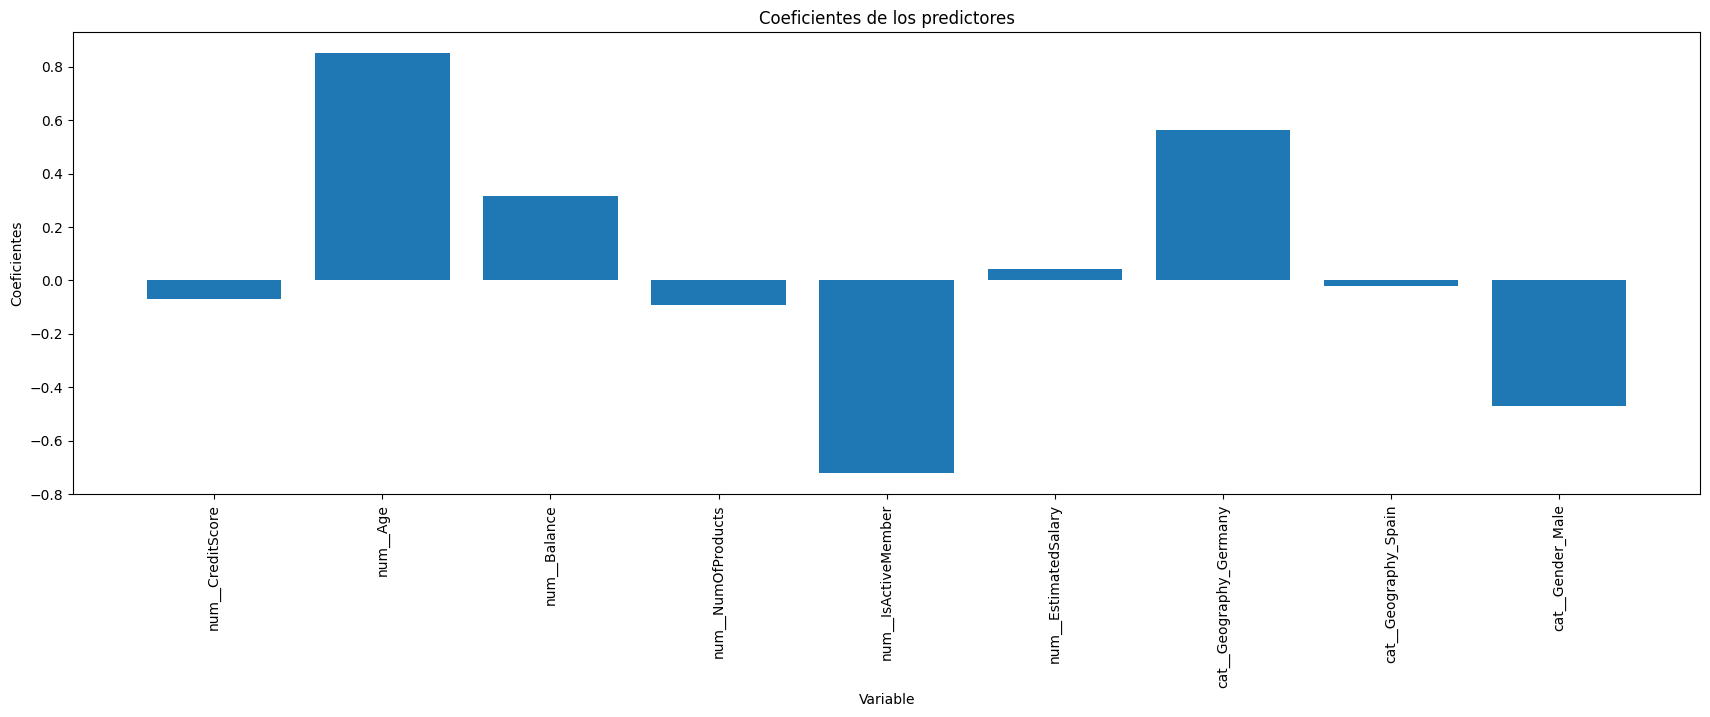

In [ ]:
# Obtener coeficientes de cada variable
best_rl = grid_reg_log.best_estimator_.named_steps['regressor']
coeficientes_rl = best_rl.coef_
coeficientes_rl_list = list(coeficientes_rl.flatten())

# Graficando coeficientes
plt.figure(figsize=(21,6))
plt.bar([i for i in column_transformed_names], coeficientes_rl_list)
plt.xticks(rotation=90)
plt.xlabel("Variable")
plt.ylabel("Coeficientes")
plt.title("Coeficientes de los predictores")

In [ ]:
# Odds Values
for i in range(0, len(coeficientes_rl_list)):
   odds_variables = math.exp(coeficientes_rl[0][i])
   print(column_transformed_names[i], ':', odds_variables)

num__CreditScore : 0.9315059448658689
num__Age : 2.341651194998056
num__Balance : 1.374389671862557
num__NumOfProducts : 0.9122183004014911
num__IsActiveMember : 0.4858272026294285
num__EstimatedSalary : 1.0419988127679087
cat__Geography_Germany : 1.7580441596057284
cat__Geography_Spain : 0.9794727372054581
cat__Gender_Male : 0.6243606157485433


In [ ]:
# Calculo métrica (datos test)
metric_rl_test = grid_reg_log.score(X_test, y_test)
print('Resultado métrica datos test:', metric_rl_test)

Resultado métrica datos test: 0.7593803356515221


### Modelo de Random Forest

In [ ]:
rf = RandomForestClassifier(criterion='gini',
                           random_state=SEED,
                           n_jobs=-1)

In [ ]:
# Creción de Pipeline procesamiento y entrenamiento
random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', rf)])

In [ ]:
%%time
param_grid_random_forest = {'regressor__max_depth': [5, 6, 7, 8, 9]}

grid_random_forest = GridSearchCV(cv = 10,
                                  param_grid = param_grid_random_forest,
                                  estimator = random_forest_pipeline,
                                  scoring = metrica,
                                  n_jobs = -1)

grid_random_forest.fit(X_train, y_train)

# Imprimir el hiperparámetro óptimo y el mejor score
print('CV mejor parametro', grid_random_forest.best_params_)
print('CV métrica:', grid_random_forest.best_score_)

CV mejor parametro {'regressor__max_depth': 9}
CV métrica: 0.8623301326193527
CPU times: user 2.15 s, sys: 144 ms, total: 2.29 s
Wall time: 57.3 s


Text(0.5, 1.0, 'Importancia de predictores')

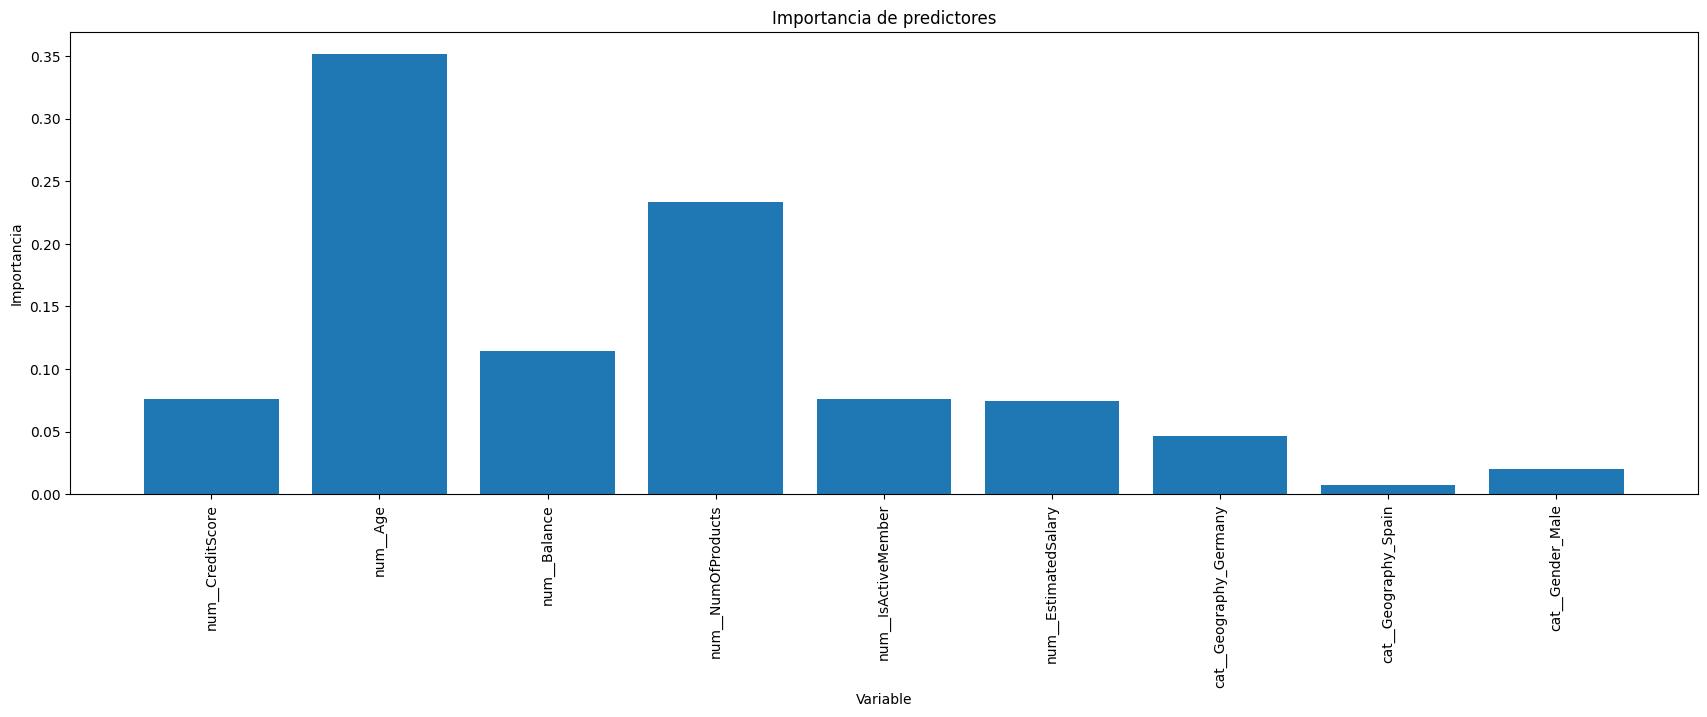

In [ ]:
# Obtener importancia de cada variable
best_rf = grid_random_forest.best_estimator_.named_steps['regressor']
importancia_rf = best_rf.feature_importances_

# # Graficando importancia
plt.figure(figsize=(21,6))
plt.bar([i for i in column_transformed_names], importancia_rf)
plt.xticks(rotation=90)
plt.xlabel("Variable")
plt.ylabel("Importancia")
plt.title("Importancia de predictores")

In [ ]:
# Calculo métrica (datos test)
metric_rf_test = grid_random_forest.score(X_test, y_test)
print('Resultado métrica datos test:', metric_rf_test)

Resultado métrica datos test: 0.8656113740859503
